In [3]:
!pip install py_midicsv pretty_midi pyFluidSynth librosa

In [4]:
import py_midicsv
import pretty_midi as pm
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import pandas as pd
import numpy as np
import csv
import os
import seaborn as sns
from collections import Counter

In [16]:
csv_base_path = '../pretrained/brq/ape/samples/csv/'

df = None

for filename in os.listdir(csv_base_path):
    if filename.endswith("_truth.csv"):
        truth_csv_file_path = os.path.join(csv_base_path, filename)
        translate_csv_file_path = os.path.join(csv_base_path, filename.replace("_truth.csv", "_translate.csv"))

        truth_df_csv = pd.read_csv(truth_csv_file_path)
        truth_df_csv = truth_df_csv.add_suffix('_truth')

        translate_df_csv = pd.read_csv(translate_csv_file_path)
        translate_df_csv = translate_df_csv.add_suffix('_translate')

        df_combined = pd.concat([truth_df_csv, translate_df_csv], axis=1)
        df_combined['file'] = filename.replace("_truth.csv", "")

        truth = []
        translate = []

        # for each row in truth calucalte the line bleu score with the translate
        for index, row in df_combined.iterrows():
            row_truth = row[[
                'beat_truth',
                'position_truth',
                'pitch_truth',
                'duration_truth',
            ]]
            row_translate = row[[
                'beat_translate',
                'position_translate',
                'pitch_translate',
                'duration_translate',
            ]]
            truth.append(row_truth)
            translate.append(row_translate)
            row_blue = sentence_bleu([row_truth], row_translate, smoothing_function=SmoothingFunction().method1)
            df_combined.loc[index, 'line_blue_score'] = row_blue

        # compute the bleu score whole file
        truth_flattened = [item for sublist in truth for item in sublist]
        translate_flattened = [item for sublist in translate for item in sublist]
        blue_score = sentence_bleu([truth_flattened], translate_flattened, smoothing_function=SmoothingFunction().method1)
        df_combined['file_blue_score'] = blue_score

        if df is None:
            df = df_combined
        else:
            df = pd.concat([df, df_combined], axis=0)



In [17]:
import matplotlib.pyplot as plt
columns_truth = [
    'beat_truth',
    'position_truth', 
    'pitch_truth', 
    'duration_truth',
    'file_blue_score'

]
columns_translate = [
    'beat_translate', 
    'position_translate', 
    'pitch_translate', 
    'duration_translate',

]

In [18]:
def plot_per_song(name):
    df_one = df[df['file'] == name]
    # Calculate mean and standard deviation for columns_truth
    mean_truth = df_one[columns_truth].mean()
    std_truth = df_one[columns_truth].std()

    # Plot columns_truth as blue points with error bars
    plt.errorbar(np.arange(len(columns_truth))*4, mean_truth, yerr=std_truth, fmt='o', color='blue', label='truth', markersize=8)

    # Calculate mean and standard deviation for columns_translate
    mean_translate = df_one[columns_translate].mean()
    std_translate = df_one[columns_translate].std()

    # Plot columns_translate as red points with error bars
    plt.errorbar(np.arange(len(columns_translate))*4+1, mean_translate, yerr=std_translate, fmt='o', color='red', label='translate',  markersize=8)

    # Set x-axis ticks and labels
    plt.xticks(np.arange(len(columns_truth))*4, columns_truth)

    # Set plot title and legend
    plt.title('Mean/Std for ' + name)
    plt.legend()

    # Show the plot
    plt.show()


truth describe


       beat_truth  position_truth  pitch_truth  duration_truth
count   27.000000       27.000000    27.000000       27.000000
mean    34.686013        4.952998    56.851135        3.016909
std     19.562421        0.879134    13.467474        1.162130
min     16.696682        2.213559    30.528814        1.542857
25%     20.659420        4.422782    48.235828        1.981090
50%     26.444068        5.268437    55.482105        3.022901
75%     44.754815        5.704900    69.396571        3.572464
max     87.436508        5.977199    76.925466        6.047619
translate describe


       beat_translate  position_translate  pitch_translate  duration_translate
count       27.000000           27.000000        27.000000           27.000000
mean        37.433882            3.487459        55.017796            3.145580
std         19.331220            0.941320        13.321558            1.399636
min          8.231579            0.781287        12.719298            0.567251


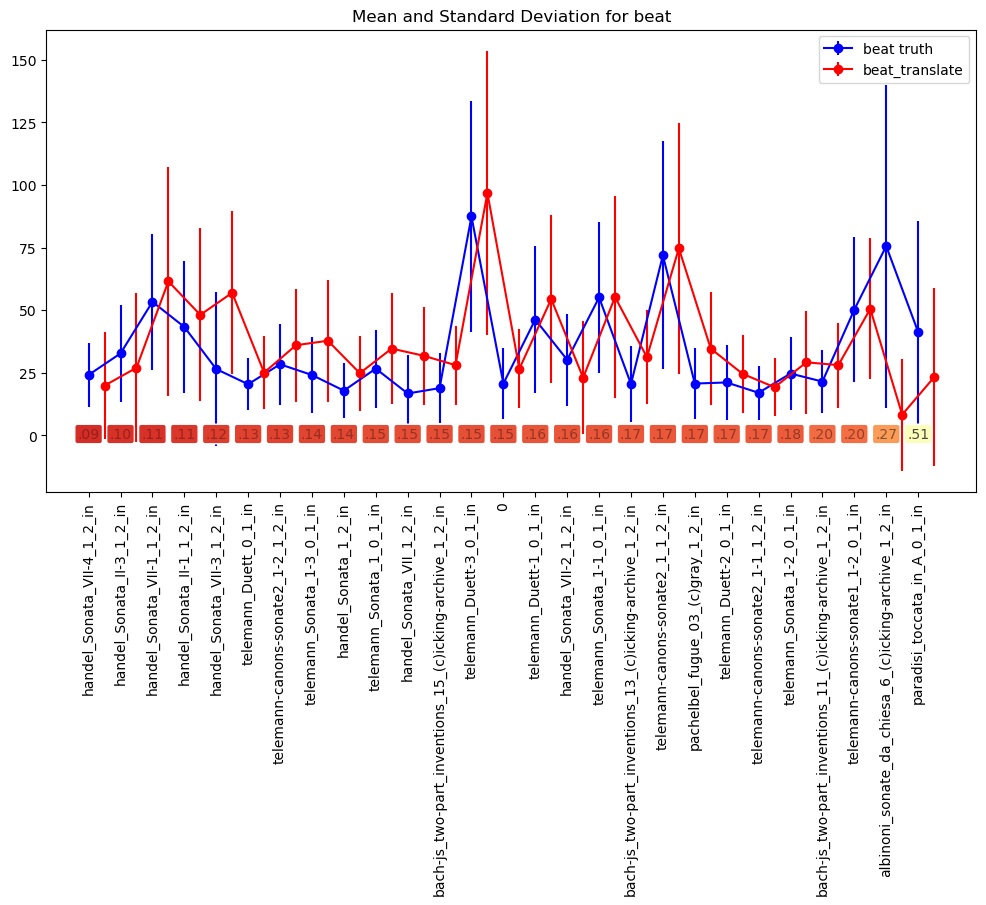

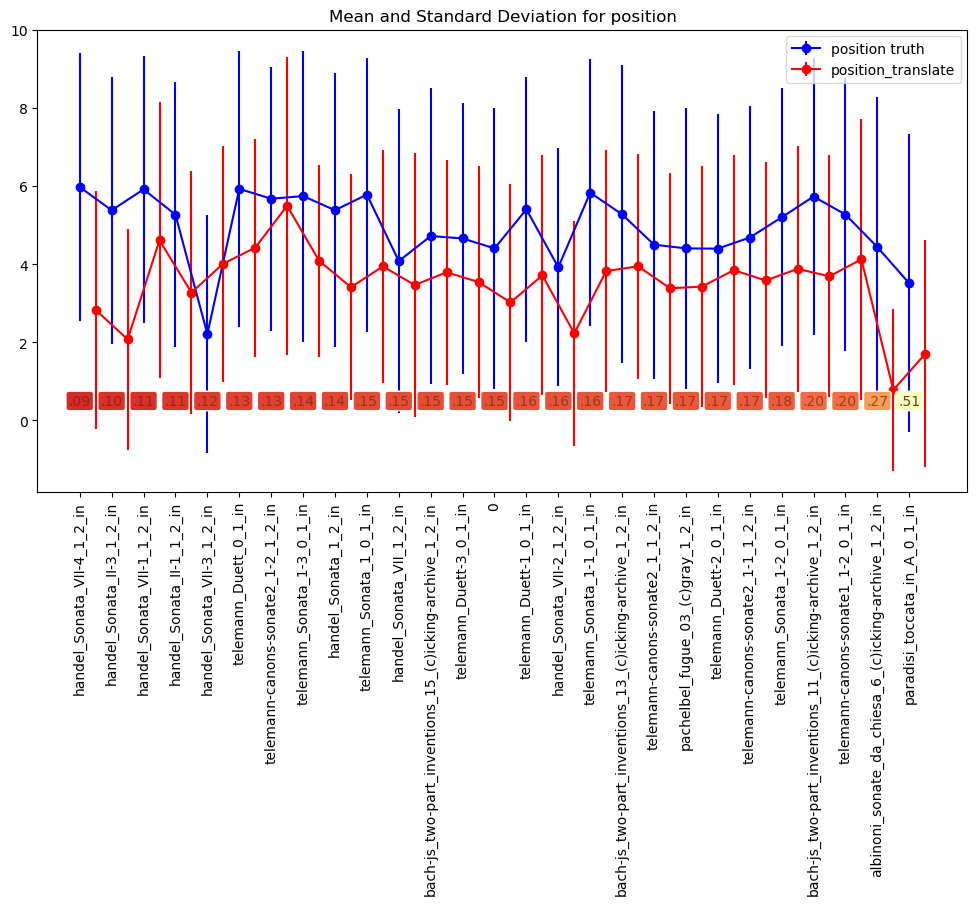

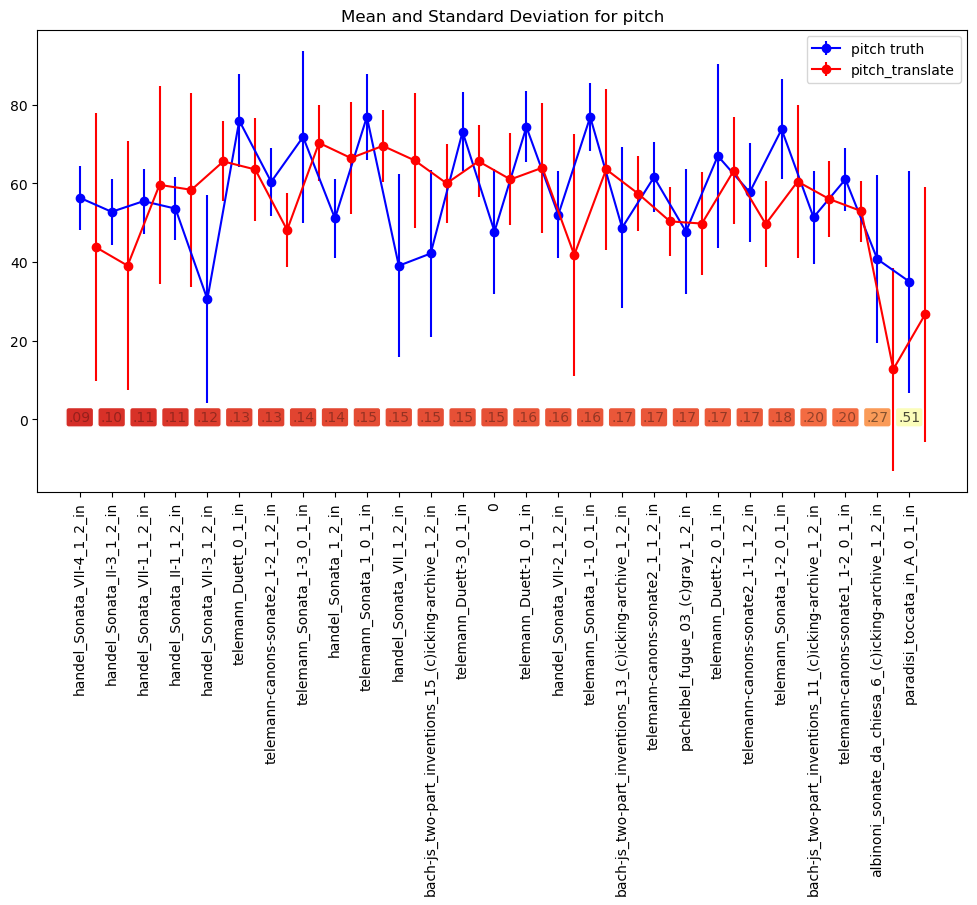

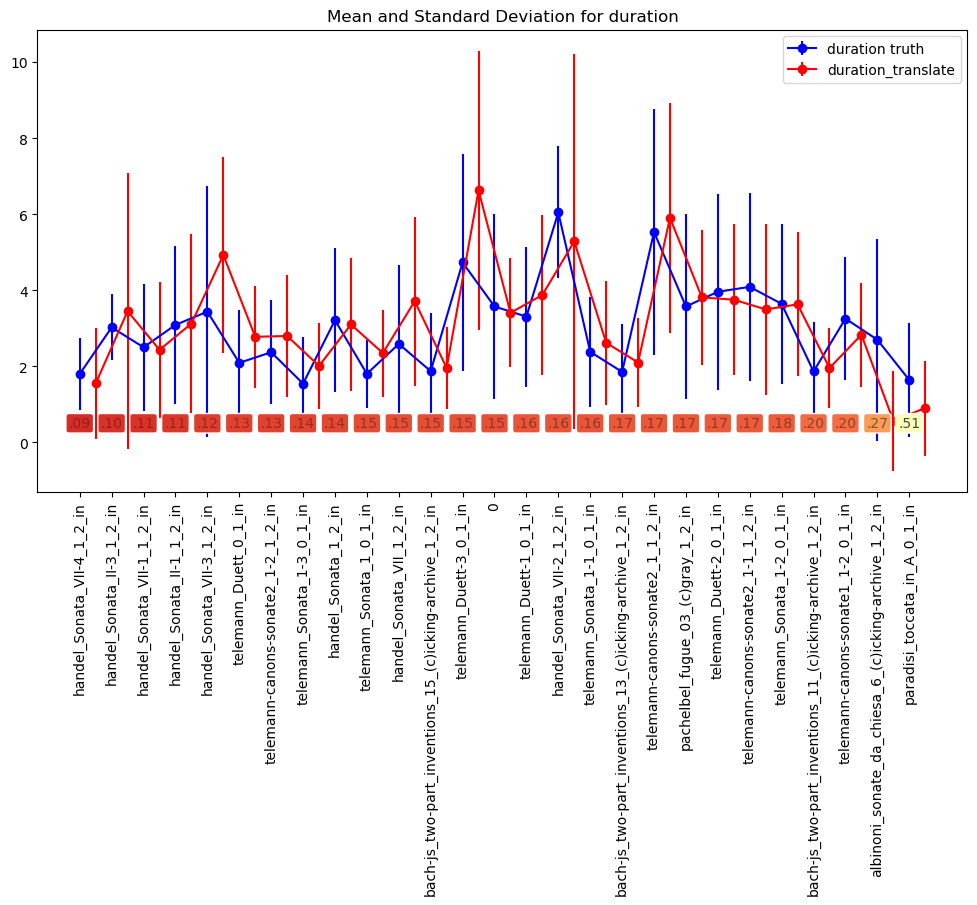

In [19]:

names = df.sort_values('file_blue_score')['file'].unique()

# Initialize empty lists for means and standard deviations
means_truth, stds_truth = [], []
means_translate, stds_translate = [], []

# Iterate over each file name
for name in names:
    # Filter the dataframe for the current file name
    df_one = df[df['file'] == name]
    
    # Calculate mean and standard deviation for columns_truth
    mean_truth = df_one[columns_truth].mean()
    std_truth = df_one[columns_truth].std()
    
    # Calculate mean and standard deviation for columns_translate
    mean_translate = df_one[columns_translate].mean()
    std_translate = df_one[columns_translate].std()
    
    # Append the means and standard deviations to the respective lists
    means_truth.append(mean_truth)
    stds_truth.append(std_truth)
    means_translate.append(mean_translate)
    stds_translate.append(std_translate)

print('truth describe\n\n', )
print(pd.DataFrame(means_truth).drop('file_blue_score', axis=1).describe())

print('translate describe\n\n', )
print(pd.DataFrame(means_translate).describe())

for column in [
    'beat',
    'position',
    'pitch',
    'duration',
]:
    # make plot larger 
    plt.figure(figsize=(12, 6))

    truth_index = columns_truth.index(f'{column}_truth')
    plt.errorbar(np.arange(len(names)), [mean[truth_index] for mean in means_truth], yerr=[std[truth_index] for std in stds_truth], fmt='o-', color='blue', label=f'{column} truth')
    plt.xticks(np.arange(len(names)), names, rotation=90)

    translate_index = columns_translate.index(f'{column}_translate')
    plt.errorbar(np.arange(len(names))+0.5, [mean[translate_index] for mean in means_translate], yerr=[std[translate_index] for std in stds_translate], fmt='o-', color='red', label=f'{column}_translate')
    plt.xticks(np.arange(len(names)), names, rotation=90)

    # Show the file_blue_score as text
    for i, name in enumerate(names):
        file_blue_score = df[df['file'] == name]['file_blue_score'].values[0]
        
        # Map the score to a color from red to green
        color = plt.cm.RdYlGn(file_blue_score)
        
        # Adjust transparency based on the score
        alpha = min(1, max(0.2, file_blue_score + 0.2))
        
        # Set the text color and transparency
        text_color = 'black' if file_blue_score < 0.5 else 'black'
        
        # Display the text with the specified color
        plt.text(i, 0.5, f'{file_blue_score:.2f}'.replace('0.', '.'), ha='center', va='center', color=text_color, alpha=alpha, bbox=dict(facecolor=color, edgecolor='white', boxstyle='round,pad=0.2'))

    plt.title(f'Mean and Standard Deviation for {column}')
    plt.legend()

    plt.show()


# Per Song Statistics

In [20]:


def load_midi(file_path):
    """
    Load a MIDI file.

    Parameters:
        file_path (str): The path to the MIDI file.

    Returns:
        PrettyMIDI: A PrettyMIDI object representing the loaded MIDI file.
    """
    midi_file = pm.PrettyMIDI(file_path)
    return midi_file


def get_midi_info(midi_file) -> list:
    """
    Extract features from loaded MIDI file.

    Parameters:
        midi_file: A loaded MIDI file (instance of PrettyMIDI class)

    Returns:
        list containing extracted features     
    """
    # Get the key of the MIDI file
    try:
        key = midi_file.key_signature_changes[0].key_number
        key = pm.key_number_to_key_name(key)
    except:
        key = None
    
    # Get time signature
    try:
        time = midi_file.time_signature_changes[0]
        time_signature = f'{time.numerator}/{time.denominator}'
        # Get number of time signature changes
        num_signature_changes = len(midi_file.time_signature_changes)
    except:
        time_signature = None
        num_signature_changes = None

    # Get tempo
    try:
        tempo = round(midi_file.estimate_tempo())
        # Get tempo changes
        num_tempo_changes = len(midi_file.get_tempo_changes())
    except:
        tempo = None
        num_tempo_changes = None

    # Find the highest and lowest notes
    all_notes = [note for instrument in midi_file.instruments for note in instrument.notes]
    
    if all_notes:
        # Find the highest and lowest notes
        highest_note = max(all_notes, key=lambda note: note.pitch)
        lowest_note = min(all_notes, key=lambda note: note.pitch)

        highest_note = pm.note_number_to_name(highest_note.pitch)
        lowest_note = pm.note_number_to_name(lowest_note.pitch)
    else:
        print("No notes found in the MIDI file.")

    # Get end time
    end_time = round(midi_file.get_end_time())

    # Get resolution
    resolution = midi_file.resolution
    
    # Get enumeration of instruments
    instruments = [i.name.strip() for i in midi_file.instruments]
    
    return [key, time_signature, num_signature_changes, tempo, num_tempo_changes, highest_note, lowest_note, end_time, resolution, instruments]

In [22]:
folder_path = '../pretrained/brq/ape/samples/mid/'

all_info = []

for file in os.listdir(folder_path):
    # Load midi file
    try:
        midi_file = load_midi(f'{folder_path}/{file}')
    except (OSError, ValueError, IndexError, EOFError, ZeroDivisionError):
        continue

    # Get basic statistics
    try:
        midi_info = get_midi_info(midi_file)
    except ValueError as e:
        print(f"Could not parse MIDI file {file}: {e}")
        continue
    
    # Store statistics
    all_info.append([file] + midi_info)

with open('truth_translate_statistics.csv', 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)

    # Write header
    csv_writer.writerow(['File', 'Key', 'Time signature', 'Num time signature changes', 'Tempo', 'Num tempo changes', 'High note', 'Low note', 'End time', 'Resolution', 'Instruments'])

    for info in all_info:
        csv_writer.writerow(info)

In [23]:
data = pd.read_csv('truth_translate_statistics.csv')
data.corr(numeric_only=True)

,Key,Time signature,Num time signature changes,Tempo,Num tempo changes,End time,Resolution
Key,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Time signature,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Num time signature changes,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Tempo,NaN,NaN,NaN,1.000000,NaN,-0.397256,NaN
Num tempo changes,NaN,NaN,NaN,NaN,NaN,NaN,NaN
End time,NaN,NaN,NaN,-0.397256,NaN,1.000000,NaN
Resolution,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
data.describe()

,Key,Time signature,Num time signature changes,Tempo,Num tempo changes,End time,Resolution
count,0.0,0.0,0.0,54.000000,54.0,54.000000,54.0
mean,NaN,NaN,NaN,179.666667,2.0,53.722222,12.0
std,NaN,NaN,NaN,27.741393,0.0,29.018157,0.0
min,NaN,NaN,NaN,108.000000,2.0,22.000000,12.0
25%,NaN,NaN,NaN,164.750000,2.0,31.250000,12.0
50%,NaN,NaN,NaN,183.000000,2.0,43.000000,12.0
75%,NaN,NaN,NaN,198.000000,2.0,67.250000,12.0
max,NaN,NaN,NaN,265.000000,2.0,150.000000,12.0


In [25]:

def plot_donut_chart(keys_counts):
    """
    Plot a donut chart for keys and their counts.
    """
    # Threshold for grouping keys into 'other' category
    threshold_percentage = 2.0

    # Filter out keys that appear in less than the threshold percentage
    total_count = sum(keys_counts.values())
    filtered_keys_counts = {key: count for key, count in keys_counts.items() if count / total_count >= threshold_percentage / 100.0}

    # Group remaining keys into 'other' category
    other_count = total_count - sum(filtered_keys_counts.values())
    filtered_keys_counts['Other'] = other_count

    labels, counts = zip(*filtered_keys_counts.items())

    # Increase the figsize to make the donut chart bigger
    fig, ax = plt.subplots(figsize=(8, 8))

    ax.pie(counts, labels=labels, autopct='%1.2f%%', startangle=90, wedgeprops=dict(width=0.4))

    # Draw a circle in the center to create a donut chart
    centre_circle = plt.Circle((0, 0), 0.70, fc='white')
    ax.add_patch(centre_circle)

    ax.axis('equal')  
    plt.title("Key Signature Distribution", loc='left', fontweight='bold', fontsize=14)
    plt.savefig('key_signatures.png')
    plt.show()


def plot_boxplot(df_column, title, x_label, y_label, fig_out):
    """
    Plot a boxplot for a DataFrame column.
    """
    # Set Seaborn style
    sns.set(style="whitegrid")

    # Create a boxplot for the DataFrame column
    plt.figure(figsize=(12, 4))
    sns.boxplot(x=df_column)

    # Set titles and labels
    plt.title(title, fontweight='bold')
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    plt.savefig(fig_out)
    plt.show()

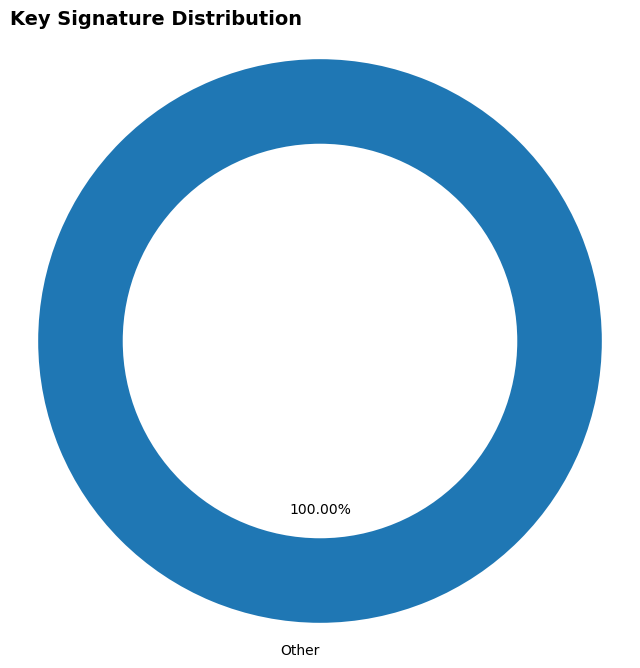

In [26]:
data = pd.read_csv('truth_translate_statistics.csv')

# Obtain all keys
keys_list = data['Key']

# Count the occurrences of each key
keys_counts = Counter(keys_list)

# Plot donut chart
plot_donut_chart(keys_counts)

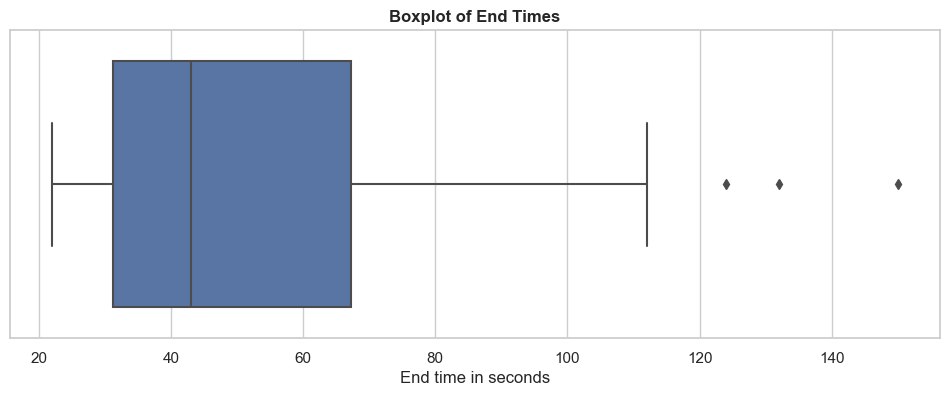

In [27]:
data = pd.read_csv('truth_translate_statistics.csv')

# Obtain all end times
end_times = data['End time']

title = 'Boxplot of End Times'
x_label = 'End time in seconds'
y_label = ''
fig_out = 'end_times.png'

plot_boxplot(end_times, title, x_label, y_label, fig_out)